In [1]:
!python -c "import torch; print(torch.__version__)"

1.12.1


# Investigation of over-smoothness w.r.t different aggregation schemes in graph neural networks


This study aims to investigate oversmoothing and its relationship with aggregation: we will consider different number of layers and visualise the corresponding node embeddings for three GNN architectures : GCN, MPNN, GAT. Specifically, we will experiment using the following dataset and methods::

1.   Dataset: CORA
2.   Model: GCN, base GNN (MPNN), GraphSAGE, GAT
3.   Dimensionality reduction method: T-SNE
4.   Quantification of smoothness: MAD
5.   Quantification of over-smoothness: modified MADGap

## Part 1. Model Implementation and Training


This part aims to investigate oversmoothing and its relationship with aggregation: we will consider different number of layers and visualise the corresponding node embeddings for three GNN architectures : GCN, MPNN, GAT. Specifically, we will experiment using the following dataset and methods::

1.   Dataset: CORA
2.   Model: GCN, base GNN (MPNN), GAT
3.   Dimensionality reduction method: T-SNE
4.   Quantification of smoothness: MAD
5.   Quantification of over-smoothness: modified MADGap

### a. Import required packages

In [2]:
import torch
import os
import typing
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets
import torch_geometric.utils as U

from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import SAGEConv

### b. Load CORA dataset

We will use `torch_geometric.datasets` to load the `Cora` dataset for node classification, which consists of 2,708 nodes, 10,556 edges, 1,433 features, and 7 classes.

In [3]:
dataset = datasets.Planetoid(
    root="./",
    name='Cora',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )
print(dataset.data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


`dataset.data.x` : input node features

`dataset.data.edge_index` : A sparce adjacent matrix with the size of *2 x n_edge*.
`dataset.data.y` : target labels

`dataset.data.train_mask` : boolean mask indicating whether an index belongs to training data

`dataset.data.val_mask` : boolean mask indicating whether an index belongs to validation data

`dataset.data.test_mask` : boolean mask indicating whether an index belongs to test data

### c. Setup GCN, MPNN, GAT

### Setup GNN
Define a GNN class for a node classification that takes five inputs: *input_dim*, *hid_dim*, *n_class*, *n_layers*, *archetype*.


In [4]:
class GNN(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      n_classes: int,
      n_layers: int,
      archetype = GCNConv,
      ):
    super().__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
      archetype: architecture of model, default to GCN
    """
    ## ------ Begin Solution ------ #
    self.n_layers = n_layers
    layers = []
    if n_layers == 0:
      layers += [nn.Linear(input_dim, n_classes)]
    else:
      for l_idx in range(n_layers-1):
          layers += [archetype(input_dim, hid_dim)]
          input_dim = hid_dim
      layers += [archetype(input_dim, n_classes)]
    self.layers = nn.ModuleList(layers)
    ## ------ End Solution ------ ##

  def forward(self, X, A) -> torch.Tensor:
    ## ------ Begin Solution ------ ##
    if self.n_layers == 0:
      X = self.layers[-1](X)
    else:
      for i in range(len(self.layers) - 1):
        X = self.layers[i](X, A)
        X = X.relu()
      X = self.layers[-1](X,A)
    X = F.softmax(X, dim = 1)
    return X
    ## ------ End Solution ------ ##

  def generate_node_embeddings(self, X, A) -> torch.Tensor:
    ## ------ Begin Solution ------ ##

    if self.n_layers == 0:
      X = self.layers[-1](X)
    else:
      for i in range(len(self.layers) - 1):
        X = self.layers[i](X, A)
        X = X.relu()
      X = self.layers[-1](X,A)
    return X
    ## ------ End Solution ------ ##
  
  def param_init(self):
    ## ------ Begin Solution ------ ##
    def _reset_module_parameters(module):
            for layer in module.children():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
                elif hasattr(layer, 'children'):
                    for child_layer in layer.children():
                        _reset_module_parameters(child_layer)

    _reset_module_parameters(self)
    ## ------ End Solution ------ ##

### Setup MPNN
Define a base GNN layer based on the equation:

$ h_i^{(t+1)} = \sigma(W^{(t)}_{self} h_i^{(t)} + W^{(t)}_{neigh} \sum_{j \in neigh(i)} h_j^{(t)})$.

The implementation of a base GNN layer is defined here, however, we will use the GraphConv layer from torch.geometric to promote consistency across experiments

In [5]:
class MPLayer(nn.Module):

    def __init__(self, input_dim, output_dim):
      super().__init__()
      self.projection_1 = nn.Linear(input_dim, output_dim)
      self.projection_2 = nn.Linear(input_dim, output_dim)

    def forward(self, node_feats, adj_matrix):
      # HW_1
      node_feats_1 = self.projection_1(node_feats)
      # HW_2
      node_feats_2 = self.projection_2(node_feats)
      # AHW_2
      node_feats_2 = torch.mm(adj_matrix, node_feats_2)
      # HW_1 + AHW_2
      node_feats = node_feats_1 + node_feats_2
      return node_feats

### Setup GAT

Define a GAT layer based on :

$ h_u^{(t+1)} = \sigma(W^{(t)} \sum_{v \in neigh(u) \cup \{u\}} \alpha_{(u,v)} h_v^{(t)})$.

where $\alpha_{u,v}$ is is the attention weight on a node $v$ with respect to $u$

In [6]:
class GAT(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      n_classes: int,
      n_layers: int,
      heads,
      ):
    super().__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
      archetype: architecture of model, default to GCN
    """
    ## ------ Begin Solution ------ #
    self.n_layers = n_layers
    layers = []
    if n_layers == 0:
      layers += [nn.Linear(input_dim, n_classes)]
    else:
      num_heads_per_layer = [1] + [heads]*(n_layers-1) + [1] if n_layers > 2 else [1, 1]
      for l_idx in range(n_layers-1):
          layers += [GATConv(input_dim * num_heads_per_layer[l_idx],
                             hid_dim,
                             num_heads_per_layer[l_idx + 1])]
          input_dim = hid_dim
      layers += [GATConv(input_dim * num_heads_per_layer[-2], n_classes, num_heads_per_layer[-1], False)]
    self.layers = nn.ModuleList(layers)
    ## ------ End Solution ------ ##

  def forward(self, X, A) -> torch.Tensor:
    ## ------ Begin Solution ------ ##
    if self.n_layers == 0:
      X = self.layers[-1](X)
    else:
      for i in range(len(self.layers) - 1):
        X = self.layers[i](X, A)
        X = X.relu()
      X = self.layers[-1](X,A)
    X = F.softmax(X, dim = 1)
    return X
    ## ------ End Solution ------ ##

  def generate_node_embeddings(self, X, A) -> torch.Tensor:
    ## ------ Begin Solution ------ ##

    if self.n_layers == 0:
      X = self.layers[-1](X)
    else:
      for i in range(len(self.layers) - 1):
        X = self.layers[i](X, A)
        X = X.relu()
      X = self.layers[-1](X,A)
    return X
    ## ------ End Solution ------ ##

  def param_init(self):
    ## ------ Begin Solution ------ ##
    def _reset_module_parameters(module):
            for layer in module.children():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
                elif hasattr(layer, 'children'):
                    for child_layer in layer.children():
                        _reset_module_parameters(child_layer)

    _reset_module_parameters(self)
    ## ------ End Solution ------ ##

### d. Implement `train` and `evaluate` functions for training a node classification model.

- Apply **Early-stopping**: stop training if the validation accuracy decreases during *k* consecutive epochs.
- Use **Adam optimizer** for training.
- Use **evaluate** function for calculating the validation accuracy in every epoch to adapt early-stopping.

In [7]:
def train(
    params: typing.Dict,
    log = False
) -> torch.nn.Module:
  """
    This function trains a node classification model and returns the trained model object.
  """
  # set device
  device = "cuda" if torch.cuda.is_available() else "cpu"

  # load dataset
  data = dataset.data
  data = data.to(device)
  adj_matrix = data.edge_index

  # Update parameters
  params["n_classes"] = dataset.num_classes # number of target classes
  params["input_dim"] = dataset.num_features # size of input features

  # Set a model
  if params['model_name'] == 'GCN':
      model = GNN(
        params["input_dim"], 
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"]
        ).to(device)
  elif params['model_name'] == 'MPNN':
      model = GNN(
        params["input_dim"],
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"],
        GraphConv,
        ).to(device)
      # adj_matrix = U.to_dense_adj(data.edge_index).squeeze(0)
  elif params['model_name'] == 'GraphSage':
      model = GNN(
        params["input_dim"],
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"],
        SAGEConv,
        ).to(device)
  elif params['model_name'] == 'GAT':
      model = GAT(
        params["input_dim"],
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"],
        params["heads"],
        ).to(device)
  else:
      raise NotImplementedError
  model.param_init()
  ## ------ Begin Solution ------ ##
  optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
  criterion = torch.nn.CrossEntropyLoss() 
  current_patience = 0 
  prev_val_acc = 0
  train_accs = []
  val_accs = []
  test_accs = []
  for epoch in range(params["epochs"]):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, adj_matrix)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    train_acc, val_acc, test_acc = evaluate(model, data, out)

    train_accs += [train_acc]
    val_accs += [val_acc]
    test_accs += [test_acc]

    if prev_val_acc > val_acc:
      current_patience += 1
    if current_patience >= params["max_patience"]:
      print('Reached max patience')
      break
    prev_val_acc = val_acc

    if log:
      print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

  print(f'Best Train Acc: {max(train_accs):.4f}, Best Val Acc: {max(val_accs):.4f}, Test Acc: {max(test_accs):.4f}')
  return model
  ## ------ End Solution ------ ##

In [8]:
def evaluate(
    model,
    data,
    out
):
    ## ------ Begin Solution ------ ##
    model.eval()
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
        accs.append(int(correct.sum()) / int(mask.sum()))  # Derive ratio of correct predictions.
    return accs
    ## ------ End Solution ------ ##

### e. Set training hyper-parameters

In [9]:
training_params = {
    "lr": 0.005,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 100,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": None, # number of layers
    "heads": 4,
    "model_name": "GCN"
}


### f. Train 6 GCN models with 0, 1, 3, 5, 7, 10 layers.

In [138]:
# torch.manual_seed(123) # set seed

In [139]:
training_params["n_layers"] = 0
GCN_0_layer = train(training_params)

Reached max patience
Best Train Acc: 0.9929, Best Val Acc: 0.5020, Test Acc: 0.4710


In [140]:
training_params["n_layers"] = 1
GCN_1_layer = train(training_params)

Reached max patience
Best Train Acc: 0.9929, Best Val Acc: 0.7120, Test Acc: 0.7190


In [141]:
training_params["n_layers"] = 3
GCN_3_layer = train(training_params)

Reached max patience
Best Train Acc: 0.9929, Best Val Acc: 0.8020, Test Acc: 0.8090


In [142]:
training_params["n_layers"] = 5
GCN_5_layer = train(training_params)

Reached max patience
Best Train Acc: 0.9857, Best Val Acc: 0.7840, Test Acc: 0.7620


In [143]:
training_params["n_layers"] = 7
GCN_7_layer = train(training_params)

Reached max patience
Best Train Acc: 0.4643, Best Val Acc: 0.3100, Test Acc: 0.2850


In [144]:
training_params["n_layers"] = 10
GCN_10_layer = train(training_params)

Reached max patience
Best Train Acc: 0.1643, Best Val Acc: 0.1620, Test Acc: 0.1570


### h. Train 5 MPNN models with 1, 3, 5, 7, 10 layers.

In [114]:
training_params["model_name"] = "MPNN"

In [115]:
training_params["n_layers"] = 1
MPNN_1_layer = train(training_params)

Reached max patience
Best Train Acc: 1.0000, Best Val Acc: 0.7460, Test Acc: 0.7580


In [116]:
training_params["n_layers"] = 3
MPNN_3_layer = train(training_params)

Reached max patience
Best Train Acc: 0.9071, Best Val Acc: 0.7540, Test Acc: 0.7520


In [117]:
training_params["n_layers"] = 5
MPNN_5_layer = train(training_params)

Reached max patience
Best Train Acc: 0.3286, Best Val Acc: 0.3200, Test Acc: 0.3370


In [118]:
training_params["n_layers"] = 7
MPNN_7_layer = train(training_params)

Reached max patience
Best Train Acc: 0.1500, Best Val Acc: 0.3260, Test Acc: 0.3110


In [119]:
training_params["n_layers"] = 10
MPNN_10_layer = train(training_params)

Reached max patience
Best Train Acc: 0.1571, Best Val Acc: 0.3160, Test Acc: 0.3190


### h. Train 5 GraphSage models with 1, 3, 5, 7, 10 layers.

In [157]:
training_params["model_name"] = "GraphSage"

In [158]:
training_params["n_layers"] = 1
GraphSage_1_layer = train(training_params)

Reached max patience
Best Train Acc: 1.0000, Best Val Acc: 0.7080, Test Acc: 0.7060


In [159]:
training_params["n_layers"] = 3
GraphSage_3_layer = train(training_params)

Reached max patience
Best Train Acc: 1.0000, Best Val Acc: 0.7780, Test Acc: 0.7940


In [160]:
training_params["n_layers"] = 5
GraphSage_5_layer = train(training_params)

Reached max patience
Best Train Acc: 0.9643, Best Val Acc: 0.7460, Test Acc: 0.7410


In [161]:
training_params["n_layers"] = 7
GraphSage_7_layer = train(training_params)

Reached max patience
Best Train Acc: 0.5571, Best Val Acc: 0.5720, Test Acc: 0.5520


In [170]:
training_params["n_layers"] = 10
GraphSage_10_layer = train(training_params)

Reached max patience
Best Train Acc: 0.1429, Best Val Acc: 0.3160, Test Acc: 0.3190


### i. Train 5 GAT models with 1, 3 5, 7, 10 layers.

In [126]:
training_params["model_name"] = "GAT"

In [127]:
training_params["n_layers"] = 1
GAT_1_layer = train(training_params)

Reached max patience
Best Train Acc: 0.9857, Best Val Acc: 0.7100, Test Acc: 0.6990


In [128]:
training_params["n_layers"] = 3
GAT_3_layer = train(training_params)

Reached max patience
Best Train Acc: 0.9929, Best Val Acc: 0.7920, Test Acc: 0.8190


In [129]:
training_params["n_layers"] = 5
GAT_5_layer = train(training_params)

Reached max patience
Best Train Acc: 0.9357, Best Val Acc: 0.7820, Test Acc: 0.7990


In [130]:
training_params["n_layers"] = 7
GAT_7_layer = train(training_params)

Reached max patience
Best Train Acc: 0.5071, Best Val Acc: 0.3440, Test Acc: 0.3300


In [131]:
training_params["n_layers"] = 10
GAT_10_layer = train(training_params)

Reached max patience
Best Train Acc: 0.3214, Best Val Acc: 0.2400, Test Acc: 0.2160


## B. Quantification

We will implement the MAD score and modified MADGap score to measure the smoothness of different models: we expect to observe a decrease in the smoothness with more layers.

In [132]:
from scipy.spatial import distance
import matplotlib.pyplot as plt

### a. Implement the function for generating MAD score:

$MAD^{tgt} = \frac{\sum_{j = 0, i = 0}^{n}\hat{D}_{ij}}{|\hat{D}|}$, a measurement for the smoothness of a GNN model where $|\hat{D}|$ is the number of non-zero entries in D

$D_{ij} = 1 - \frac{h_ih_j}{||h_i||||h_j||}$, where $D$ denotes the cosine distance between node embeddings

Our modified MADGap uses labels to determine the class of nodes instead of topological distances, which is more accurate.

In [164]:
def MAD(embd, target_rep, labels, curr_label):
    # only consider embeddings of nodes in other classes
    embd_others = [embd[i] for i in range(len(embd)) if labels[i] != curr_label]
    embd_self = [embd[i] for i in range(len(embd)) if labels[i] == curr_label]
    cos_distances_others = [distance.cosine(rep, target_rep) for rep in embd_others]
    cos_distances_self = [distance.cosine(rep, target_rep) for rep in embd_self]
    if len(cos_distances_others) == 0:
        return 0
    if len(cos_distances_self) == 0:
        return 0
    MADGap = abs(sum([abs(d) for d in cos_distances_others])/len(cos_distances_others) - \
             sum([abs(d) for d in cos_distances_self])/len(cos_distances_self))
    return MADGap

In [150]:
def generate_MAD(model: nn.Module):
  """
    Args:
      model: model object for generating features
  """
    ## ------ Begin Solution ------ ##
  data = dataset.data
  mask = data.val_mask
  adj_matrix = data.edge_index
  embd = model.generate_node_embeddings(data.x,
                                        adj_matrix).detach().cpu().numpy()[mask]
  labels = data.y[mask].detach().cpu().numpy()
  MAD_list = [MAD(embd,embd[i], labels, labels[i]) for i in range(len(embd))]
  return sum(MAD_list)/len(MAD_list)

### b. Measure smoothness for different GNNs

In [151]:
MADGap_GCN = [generate_MAD(GCN_1_layer), generate_MAD(GCN_3_layer), generate_MAD(GCN_5_layer), generate_MAD(GCN_7_layer), generate_MAD(GCN_10_layer)]

In [152]:
MADGap_MPNN = [generate_MAD(MPNN_1_layer), generate_MAD(MPNN_3_layer),generate_MAD(MPNN_5_layer),generate_MAD(MPNN_7_layer),generate_MAD(MPNN_10_layer)]

In [163]:
MADGap_GraphSage = [generate_MAD(GraphSage_1_layer), generate_MAD(GraphSage_3_layer),generate_MAD(GraphSage_5_layer),generate_MAD(GraphSage_7_layer),generate_MAD(GraphSage_10_layer)]

In [154]:
MADGap_GAT = [generate_MAD(GAT_1_layer), generate_MAD(GAT_3_layer),generate_MAD(GAT_5_layer),generate_MAD(GAT_7_layer),generate_MAD(GAT_10_layer)]

In [155]:
print("GCN MAD score: ", MADGap_GCN)
print("GraphSAGE MAD score: ", MADGap_GraphSage)
print("MPNN MAD score: ", MADGap_MPNN)
print("GAT MAD score: ", MADGap_GAT)

GCN MAD score:  [0.286514775409807, 0.5590631664848101, 0.6141434456534102, 0.23940083480281293, 1.182953954736388e-09]
GraphSAGE MAD score:  [0.18051754095516823, 0.6519916419792321, 0.40650213339171437, 0.5378283087750473, 0.0]
MPNN MAD score:  [0.21942061422849019, 0.43683762444143204, 0.018706456321153666, 0.001289365768540359, 0.0003205139926914667]
GAT MAD score:  [0.23199038962553165, 0.5617026534355252, 0.6088942989205213, 0.5253937579804419, 0.15689560388223156]


### c. Visualizing over-smoothness

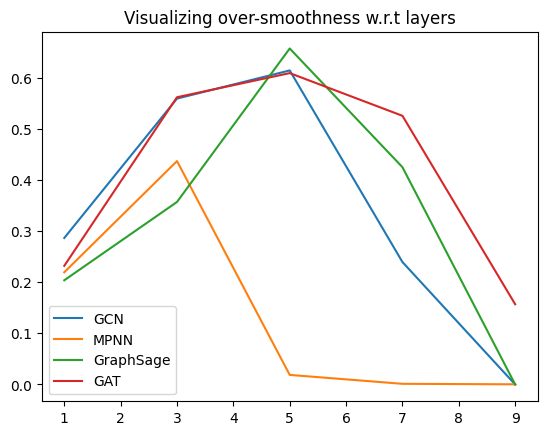

In [165]:
layers = [1,3,5,7,9]
plt.title("Visualizing over-smoothness w.r.t layers")
plt.plot(layers, MADGap_GCN, label = "GCN")
plt.plot(layers, MADGap_MPNN, label = "MPNN")
plt.plot(layers, MADGap_GraphSage, label = "GraphSage")
plt.plot(layers, MADGap_GAT, label = "GAT")
plt.legend()
plt.show()

## C. Visualisation

We will generate node embeddings, reduce their dimensions, and finally visualsie these embeddings: we expect to empirically observe that the embeddings become more and more similar with more layers.

### a. Import required packages

In [41]:
import pandas as pd
import warnings

from sklearn.manifold import TSNE
warnings.simplefilter(action='ignore', category=FutureWarning)

### b. Implement a function for demensionality reduction

In [66]:
def dimension_reduction(model: nn.Module) -> pd.DataFrame:
  """
    Args:
      model: model object for generating features
    
    Return:
      pd.DataFrame: A data frame that has 'dimension 1', 'dimension 2', and 'labels' as a column
  """
    ## ------ Begin Solution ------ ##
  data = dataset.data
  mask = data.val_mask
  adj_matrix = data.edge_index
  embd = model.generate_node_embeddings(data.x,
                                        adj_matrix).detach().cpu().numpy()
  embd = embd[mask]
  z = TSNE(n_components=2).fit_transform(embd)
  labels = data.y[mask].detach().cpu().numpy()
  d = {'x': z[:, 0], 'y': z[:, 1], 'labels': labels}
  df = pd.DataFrame(data=d)
  return df
    ## ------ End Solution ------ ##

### c. Generate reduced embeddings for each model and save them in a dictionary object

In [200]:
feature_dict = {
    "3_layer_GCN": dimension_reduction(GCN_3_layer),
    "5_layer_GCN": dimension_reduction(GCN_5_layer),
    "10_layer_GCN": dimension_reduction(GCN_10_layer),
    "3_layer_MPNN": dimension_reduction(MPNN_3_layer),
    "5_layer_MPNN": dimension_reduction(MPNN_5_layer),
    "10_layer_MPNN": dimension_reduction(MPNN_10_layer),
    "3_layer_GraphSage": dimension_reduction(GraphSage_3_layer),
    "5_layer_GraphSage": dimension_reduction(GraphSage_5_layer),
    "10_layer_GraphSage": dimension_reduction(GraphSage_10_layer),
    "3_layer_GAT": dimension_reduction(GAT_3_layer),
    "5_layer_GAT": dimension_reduction(GAT_5_layer),
    "10_layer_GAT": dimension_reduction(GAT_10_layer),
}

### d. Implement a function for the visualisation and draw scatter plots

In [201]:
def visualise(feature_dict: typing.Dict) -> None:
    ## ------ Begin Solution ------ ##
    for key in feature_dict:
      df = feature_dict[key]
      plt.figure(figsize=(1,1))
      df.plot.scatter(x='x',y='y',c='labels',cmap="Set2")
      plt.show()
    ## ------ End Solution ------ ##

In [202]:
def subPlots(n_layers):
    fig, axs = plt.subplots(2, 2)
    GCN_df = feature_dict[str(n_layers) + "_layer_GCN"]
    MPNN_df = feature_dict[str(n_layers) + "_layer_MPNN"]
    GraphSage_df = feature_dict[str(n_layers) + "_layer_GraphSage"]
    GAT_df = feature_dict[str(n_layers) + "_layer_GAT"]
    axs[0, 0].scatter(x=GCN_df['x'],y=GCN_df['y'], c=GCN_df['labels'], cmap="Set2")
    axs[0, 0].set_title('GCN')
    axs[0, 1].scatter(x=MPNN_df['x'],y=MPNN_df['y'], c=MPNN_df['labels'], cmap="Set2")
    axs[0, 1].set_title('base GNN')
    axs[1, 0].scatter(x=GraphSage_df['x'],y=GraphSage_df['y'], c=GraphSage_df['labels'], cmap="Set2")
    axs[1, 0].set_title('GraphSage')
    axs[1, 1].scatter(x=GAT_df['x'],y=GAT_df['y'], c=GAT_df['labels'], cmap="Set2")
    axs[1, 1].set_title('GAT')
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

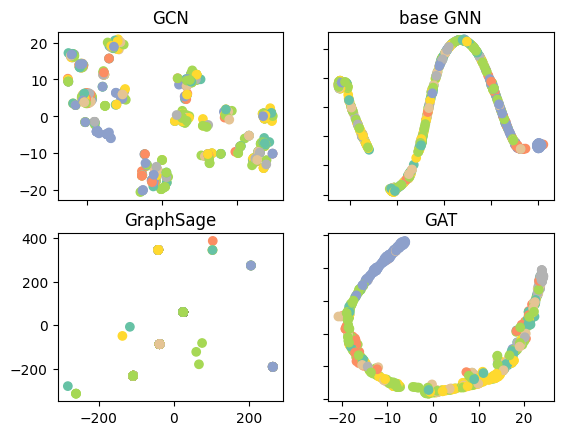

In [203]:
subPlots(10)

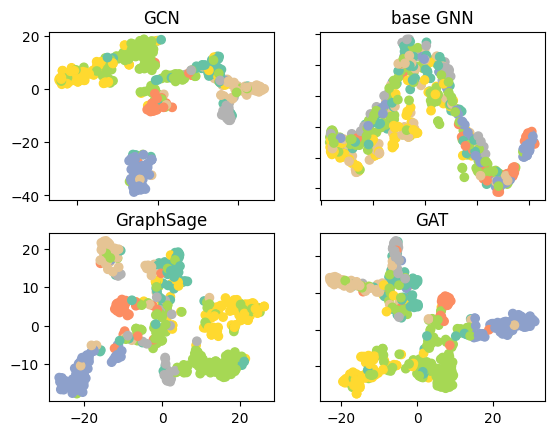

In [205]:
subPlots(5)

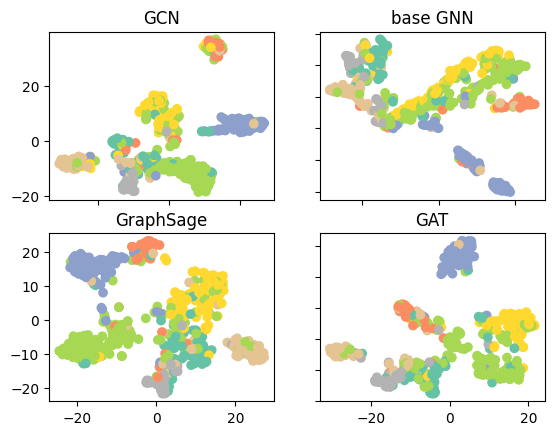

In [206]:
subPlots(3)